# Mobile Phone Reviews Analysis - Text Mining

## Importing data 

In [178]:
import pandas as pd
import os
import datetime
import nltk 
import re
import numpy as np
import gensim
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#Note: You will need to install the packages below to use them
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [179]:
#Just write your directory here
#data_dir = 'C:/Users/owzhe/Downloads/14-million-cell-phone-reviews/'
data_dir = 'C:/Users/Eugene/Desktop/Modules/Text Mining and Language Processing (IS450)/Project/Potential datasets/14-million-cell-phone-reviews/'
reviews_files = os.listdir(data_dir)

reviews_df = pd.DataFrame()

for file in reviews_files:
    current = pd.read_csv(data_dir + file, encoding = "ISO-8859-1")
    reviews_df = reviews_df.append(current)
    

In [180]:
print(len(reviews_df))
reviews_df.head()

1415133


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


## EDA 

In [181]:
# Taking only the reviews that are in english
reviews_en_df = reviews_df[reviews_df['lang'] == 'en']
print(len(reviews_en_df))
reviews_en_df.head()

554746


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [182]:
print(len(reviews_en_df['phone_url'].unique()))
print(reviews_en_df['phone_url'].unique())

4533
['/cellphones/samsung-galaxy-s8/'
 '/cellphones/samsung-galaxy-s6-edgeplus/'
 '/cellphones/samsung-galaxy-s8-plus/' ... '/cellphones/ericsson-pf-768/'
 '/cellphones/motorola-m3288/' '/cellphones/maxon-mx-3204/']


In [183]:
# Creating the function to return the phone model from the URL
def phone_model(url):
    phone_type = ' '.join(url[12:-1].split('-')).title()
    return phone_type

In [184]:
# Applying the phone_model function on the url 
reviews_en_df['phone_model'] = reviews_en_df['phone_url'].apply(phone_model)

C:\Users\Eugene\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:
print(len(reviews_en_df['phone_model'].unique()))

4533


In [186]:
# Creating another copy of the reviews_df
reviews_copy_df = reviews_en_df.copy()

In [187]:
# Found out that the dates are abit off - majority are in month/day/year but there is around 20k that is day/month/year
def check_date(row_date):
    month, day, year = row_date.split('/')
    isValid = True
    try:
        datetime.datetime(int(year), int(month), int(day))
    except:
        isValid = False
    
    return isValid

In [188]:
# Creating a year column
def review_year(row_date):
    month, day, year = row_date.split('/')

    return year

In [189]:
reviews_copy_df['date_check'] = reviews_copy_df['date'].apply(check_date)
reviews_copy_df['year'] = reviews_copy_df['date'].apply(review_year)
reviews_copy_df.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,date_check,year
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8,True,2017
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8,Samsung Galaxy S8,True,2017
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung Galaxy S8,True,2017
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8,True,2017
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8,True,2017


In [190]:
# Checking the number of wrong and correct dates 
wrong_dates = reviews_copy_df[reviews_copy_df['date_check'] == False]
print('No. of wrong dates:', len(wrong_dates))

correct_dates = reviews_copy_df[reviews_copy_df['date_check'] == True]
print('No. of correct dates:', len(correct_dates))

No. of wrong dates: 23448
No. of correct dates: 531298


In [191]:
# Created a function to clean the date for the incorrect date format
def clean_date(date):
    month, day, year = date.split('/')
    return '/'.join([day, month, year])

#     for index, row in reviews_df.iterrows():
#         month, day, year = row['date'].split('/')
#         if row['date_check'] == False:
#             reviews_df.loc[index, 'date'] = '/'.join([day, month, year])
#             row['date_check'] = True
#     return reviews_df

In [192]:
# Clean up the date format of the dataframe with wrong dates
wrong_dates['date'] = wrong_dates['date'].apply(clean_date)
wrong_dates

C:\Users\Eugene\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,date_check,year
1,/cellphones/samsung-s7262-duos-galaxy-ace/,11/17/2015,en,in,Zopper,zopper.com,10.0,10.0,Decent Functions and Easy to Operate Pros:- Th...,Expert Review,Samsung Galaxy Star Pro S7262 Black,Samsung S7262 Duos Galaxy Ace,False,2015
2,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,4.0,10.0,Not Good Phone such price. Hang too much and v...,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
3,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,6.0,10.0,not bad for features,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
4,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,10.0,10.0,Excellent product,NHK,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
5,/cellphones/samsung-s7262-duos-galaxy-ace/,10/27/2015,en,in,Amazon,amazon.in,8.0,10.0,Good in reasonable price,Rupali,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97303,/cellphones/motorola-razr-432872/,5/13/2006,en,gb,Ciao,ciao.co.uk,8.0,10.0,I bought this phone originally because I decid...,tblake7,Motorola RAZR,Motorola Razr 432872,False,2006
97304,/cellphones/motorola-razr-432872/,3/18/2006,en,gb,Ciao,ciao.co.uk,8.0,10.0,"After making the switch from an old V60 TDMA, ...",sting_of_the_scorpion,Motorola RAZR,Motorola Razr 432872,False,2006
97906,/cellphones/alcatel-ot-918d/,1/30/2015,en,us,Amazon,amazon.com,10.0,10.0,Excelente producto,norbys moreno,Alcatel One Touch 918S Mix Unlocked GSM Phone ...,Alcatel Ot 918D,False,2015
97910,/cellphones/alcatel-ot-918d/,11/25/2013,en,us,Amazon,amazon.com,4.0,10.0,"Older Android version, too many junky apps and...","Amazon Customer ""Jarod""",Alcatel One Touch 918S Mix Unlocked GSM Phone ...,Alcatel Ot 918D,False,2013


In [193]:
# Returning the cleaned dataframe use for analysis 
cleaned_df = correct_dates.append(wrong_dates, ignore_index=True)
cleaned_df = cleaned_df[cleaned_df['year'].astype(int) >= 2013]
cleaned_df.drop(columns=['phone_url', 'date_check', 'year'], inplace=True)

In [194]:
# Checking null rows
null_columns = cleaned_df.columns[cleaned_df.isna().any()]
cleaned_df[null_columns].isna().sum()

score         158
score_max     158
extract      3448
author        305
dtype: int64

In [195]:
cleaned_df.dropna(subset=['extract'], inplace=True)
len(cleaned_df)

400063

In [196]:
#Removing pre-2007 reviews
# date_list = cleaned_df.loc[:,'date'].tolist()
# year_list = []
# for dates in date_list:
#     year = dates[-4:]
#     if (int(year)>=2007):
#         year_list.append(year)
#     else:
#         year_list.append("drop")
# cleaned_df.insert(0, 'year', year_list)
# cleaned_df.drop( cleaned_df[ cleaned_df['year'] == "drop" ].index , inplace=True)
# cleaned_df.drop(['year'], axis=1, inplace = True)
# len(cleaned_df)

## Storing/Opening pickle file for the cleaned dataframe 

In [16]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE CLEANED DATAFRAME FROM ABOVE @@@@@@@@@###
#pickle.dump(cleaned_df, open("cleaned_reviews_df.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE CLEANED DATAFRAME FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
cleaned_df = pickle.load(open("cleaned_reviews_df.pkl", "rb"))

In [17]:
cleaned_df.head()

,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model
0,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8
1,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8,Samsung Galaxy S8
2,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung Galaxy S8
3,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8
4,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8


In [18]:
## Create an index series to find back the actual extract later on
import numpy as np
import pandas as pd

data_len = len(cleaned_df)
index_series = np.arange(data_len)

cleaned_df['index'] = index_series


In [19]:
import re

sentence_list = []
index_list = []
scores = cleaned_df['score'].tolist()
index_score_list = []

extract_list = list(cleaned_df['extract'])

for num in index_series:
    sentences = extract_list[num]
    sentence_break = re.split(r'[.?!]', sentences)
    for sentence in sentence_break:
        if len(sentence) > 0:
            sentence_list.append(sentence.strip())
            index_list.append(num)
            index_score_list.append(scores[num])

In [21]:
sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentence_list
sentences_df['index'] = index_list

sentences_df.dropna(inplace=True)

sentences_df.shape

(1025939, 2)

In [12]:
sentences_df

,sentence,index
0,As a diehard Samsung fan who has had every Sam...,0
1,I am amazed at some of the reviews and think p...,0
2,The battery life is amazing,0
3,Love the phone,1
4,the phone is sleek and smooth and beautiful I ...,1
...,...,...
1025934,Came right on timr,400060
1025935,Excelente producto,400061
1025936,"Older Android version, too many junky apps and...",400062
1025937,I had one die and returned it to my cell provi...,400062


#  #1 LDA Gensim Model - All Text 

In [ ]:
import nltk 
import re

def clean_sentence(sentence_list):
    stop_list = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.word_tokenize

    sentence_list  = [tokenizer(sentence.lower()) for sentence in sentence_list]
    sentence_list = [[w for w in sentence if re.search('^[a-z]+$',w)] for sentence in sentence_list]
    sentence_list = [[w for w in sentence if w not in stop_list] for sentence in sentence_list]

    return sentence_list

In [ ]:
sentence_list = sentences_df['sentence'].values.tolist()
sentences_df['bag of words'] = clean_sentence(sentence_list)

In [ ]:
sentences_words = sentences_df['bag of words'].values.tolist()

In [ ]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
sentence_dict = gensim.corpora.Dictionary(sentences_words)

# Returning the word vector for each extract from the gensim dict of words
sentence_vecs = [sentence_dict.doc2bow(words) for words in sentences_words]

In [ ]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

iterations = 100
passes = 1
gensim_all_texts_list = []

for num_topic in range(3, 10):
    model_val = []
    gensim_all_texts = gensim.models.ldamodel.LdaModel(corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic, iterations = iterations, passes = passes)
    coh_model = CoherenceModel(model=gensim_all_texts, texts=sentences_words, dictionary=sentence_dict, coherence='c_v')
    model_val.append(gensim_all_texts)
    model_val.append(coh_model.get_coherence())
    model_val.append(num_topic)
    gensim_all_texts_list.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

coh_val = [coh for model, coh, topic in gensim_all_texts_list]

x = range(3, 10)
plt.plot(x, coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Gensim LDA Model - topics

for model in gensim_all_texts_list:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE GENSIM MODELS FROM ABOVE @@@@@@@@@###
#pickle.dump(gensim_all_texts_list, open("gensim_all_texts.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_all_texts_list = pickle.load(open("gensim_all_texts.pkl", "rb"))

# #1 LDA Mallet Model - All Text

In [ ]:
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

mallet_all_texts_list = []

for num_topic in range(3, 10):
    model_val = []
    mallet_all_texts = gensim.models.wrappers.LdaMallet(mallet_path, corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    mallet_coh_model = CoherenceModel(model=mallet_all_texts, texts=sentences_words, dictionary=sentence_dict, coherence='c_v')
    model_val.append(mallet_all_texts)
    model_val.append(mallet_coh_model.get_coherence())
    model_val.append(num_topic)
    mallet_all_texts_list.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(mallet_coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

mallet_coh_val = [coh for model, coh, topic in mallet_all_texts_list]

x = range(3, 10)
plt.plot(x, mallet_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics

for model in mallet_all_texts_list:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(mallet_all_texts_list, open("mallet_all_texts.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_all_texts_list = pickle.load(open("mallet_all_texts.pkl", "rb"))

# #2 LDA Gensim Model - Nouns Only

In [48]:
sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentence_list
sentences_df['index'] = index_list
sentences_df.dropna(inplace=True)

sentences_df.head()

,sentence,index
0,As a diehard Samsung fan who has had every Sam...,0
1,I am amazed at some of the reviews and think p...,0
2,The battery life is amazing,0
3,Love the phone,1
4,the phone is sleek and smooth and beautiful I ...,1


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

In [49]:
import nltk

stop_list = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.word_tokenize
extra_stop_words = ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', 'motorola', 'android', 'verizon', 'i', '%', 't', 's']
extra_stop_words += ['s4', 's5', 's6', 's7', 's3', 's8', 's9', 'm9', 'moto']
extra_stop_words += ['good', 'excellent','awesome','great','nice','happy','perfect','bad','apple','nexus','model','fine','amazing','lot','thing','year','smart','month','mobile','phone','day','fantastic','good','sony','motorola','windows','nokia','oppo','huawei','xiaomi','redmi','t-mobile','blackberry','lumia','smartphone','google','ios','wife']

def get_nouns(sentence_row):

    noun_list = []
    sentence = nltk.pos_tag(tokenizer(sentence_row.lower()))
    for w, pos in sentence: 
        if pos == 'NN' and w not in extra_stop_words:
            noun_list.append(w)
    
    return noun_list

#     sentence_list = [tokenizer(sentence.lower()) for sentence in sentence_list]
#     sentence_tagging = [nltk.pos_tag(sentence) for sentence in sentence_list] 
#     sentence_nouns = [w for w in sentence if is_noun(w) for sentence in sentence_list]

In [50]:
sentences_df['sentence_tags'] = sentences_df['sentence'].apply(get_nouns)

In [51]:
sentences_df = sentences_df[sentences_df['sentence_tags'].str.len()>0]

In [52]:
sentences_df.head()

,sentence,index,sentence_tags
0,As a diehard Samsung fan who has had every Sam...,0,"[diehard, fan, series, upgrade]"
1,I am amazed at some of the reviews and think p...,0,[device]
2,The battery life is amazing,0,"[battery, life]"
5,Adequate feel,2,[feel]
6,Nice heft,2,[heft]


In [53]:
sentence_tags = sentences_df['sentence_tags'].values.tolist()
print(len(sentence_tags))

750878


In [54]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
sentence_dict = gensim.corpora.Dictionary(sentence_tags)

# Returning the word vector for each extract from the gensim dict of words
sentence_vecs = [sentence_dict.doc2bow(words) for words in sentence_tags]

In [ ]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

gensim_noun_models = []

for num_topic in range(3, 10):
    model_val = []
    gensim_nouns = gensim.models.ldamodel.LdaModel(corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    coh_model = CoherenceModel(model=gensim_nouns, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(gensim_nouns)
    model_val.append(coh_model.get_coherence())
    model_val.append(num_topic)
    gensim_noun_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

coh_val = [coh for model, coh, topic in gensim_noun_models]

x = range(3, 10)
plt.plot(x, coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics
for model in gensim_noun_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(gensim_noun_models, open("gensim_noun_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_noun_models = pickle.load(open("gensim_noun_models.pkl", "rb"))

# #2 LDA Mallet Model - Nouns Only

In [55]:
import gensim
import os 
from gensim.models import CoherenceModel

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

mallet_noun_models = []

for num_topic in range(3, 10):
    model_val = []
    mallet_nouns_only = gensim.models.wrappers.LdaMallet(mallet_path, corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    mallet_coh_model = CoherenceModel(model=mallet_nouns_only, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(mallet_nouns_only)
    model_val.append(mallet_coh_model.get_coherence())
    model_val.append(num_topic)
    mallet_noun_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(mallet_coh_model.get_coherence()))

Topic 3 Score: 0.16121873323202263
Topic 4 Score: 0.18563557456218163
Topic 5 Score: 0.22064457408217203
Topic 6 Score: 0.1990150532513182
Topic 7 Score: 0.24444587140876628
Topic 8 Score: 0.23657734836154282
Topic 9 Score: 0.2614892391479027


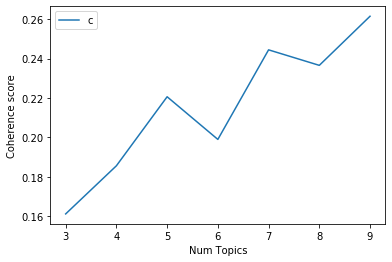

In [56]:
import matplotlib.pyplot as plt

mallet_coh_val = [coh for model, coh, topic in mallet_noun_models]

x = range(3, 10)
plt.plot(x, mallet_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Mallet LDA Model - topics
for model in mallet_noun_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.16121873323202263
Topic 1: price, screen, product, device, size, note, edge, charger, case, range
Topic 2: battery, camera, quality, life, problem, performance, display, design, issue, sound
Topic 3: time, product, card, apps, sim, money, memory, service, work, cell
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.18563557456218163
Topic 1: camera, quality, screen, performance, display, size, design, sound, ram, experience
Topic 2: money, card, apps, sim, device, memory, note, service, work, product
Topic 3: problem, time, screen, issue, edge, charger, bit, case, call, brand
Topic 4: battery, price, product, life, time, range, backup, charge, market, budget
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.22064457408217203
Topic 1: card, apps, sim, memory, work, ram, call, processor, version, network
Topic 2: price, product, money, device, service,

In [88]:
type(mallet_noun_models[3][0])

gensim.models.wrappers.ldamallet.LdaMallet

In [90]:
from gensim.test.utils import datapath 
# mallet_noun_models[3][0].save(datapath('mallet_test'))
mallet_noun_models[3][0].save('mallet_test.pkl')

In [58]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(mallet_noun_models, open("mallet_noun_models2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_noun_models = pickle.load(open("mallet_noun_models.pkl", "rb"))

# #3 LDA Gensim Model - Nouns and Adjectives

In [ ]:
sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentence_list
sentences_df['index'] = index_list
sentences_df.dropna(inplace=True)

sentences_df.head()

In [ ]:
import nltk

stop_list = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.word_tokenize
extra_stop_words = ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', 'motorola', 'android', 'verizon', 'i', '%', 't', 's']
extra_stop_words += ['s4', 's5', 's6', 's7', 's3', 's8', 's9', 'm9', 'moto']

def get_nouns_adj(sentence_row):

    noun_list = []
    sentence = nltk.pos_tag(tokenizer(sentence_row.lower()))
    for w, pos in sentence: 
        if pos == 'NN' or pos == 'JJ':
            if w not in extra_stop_words:
                noun_list.append(w)
    
    return noun_list


In [ ]:
sentences_df['sentence_tags'] = sentences_df['sentence'].apply(get_nouns_adj)

In [ ]:
sentences_df.head()

In [ ]:
sentences_df = sentences_df[sentences_df['sentence_tags'].str.len()>0]
sentences_df.head()

In [ ]:
sentence_tags = sentences_df['sentence_tags'].values.tolist()

In [ ]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
sentence_dict = gensim.corpora.Dictionary(sentence_tags)

# Returning the word vector for each extract from the gensim dict of words
sentence_vecs = [sentence_dict.doc2bow(words) for words in sentence_tags]

In [ ]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

gensim_noun_adj_models = []
coh_val = []
model_topics = []

for num_topic in range(3, 10):
    model_val = []
    gensim_nouns_adj = gensim.models.ldamodel.LdaModel(corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    coh_model = CoherenceModel(model=gensim_nouns_adj, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(gensim_nouns_adj)
    model_val.append(coh_model.get_coherence())
    model_val.append(num_topic)
    gensim_noun_adj_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

gensim_coh_val = [coh for model, coh, topic in gensim_noun_adj_models]

x = range(3, 10)
plt.plot(x, gensim_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics
for model in gensim_noun_adj_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
# pickle.dump(gensim_noun_adj_models, open("gensim_noun_adj_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
gensim_noun_adj_models = pickle.load(open("gensim_noun_adj_models.pkl", "rb"))

# #3 LDA Mallet Model - Nouns and Adjectives

In [ ]:
import gensim
import os 
from gensim.models import CoherenceModel

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

mallet_noun_adj_models = []

for num_topic in range(3, 10):
    model_val = []
    mallet_noun_adj = gensim.models.wrappers.LdaMallet(mallet_path, corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    mallet_coh_model = CoherenceModel(model=mallet_noun_adj, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(mallet_noun_adj)
    model_val.append(mallet_coh_model.get_coherence())
    model_val.append(num_topic)
    mallet_noun_adj_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(mallet_coh_model.get_coherence()))

In [23]:
import matplotlib.pyplot as plt

mallet_coh_val = [coh for model, coh, topic in mallet_noun_adj_models]

x = range(3, 10)
plt.plot(x, mallet_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics
for model in mallet_noun_adj_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [32]:
mallet_noun_adj_models[5][0][sentence_vecs]


[[(0, 0.11363636363636363),
  (1, 0.11363636363636363),
  (2, 0.11363636363636363),
  (3, 0.11363636363636363),
  (4, 0.11363636363636363),
  (5, 0.1318181818181818),
  (6, 0.18636363636363637),
  (7, 0.11363636363636363)],
 [(0, 0.1201923076923077),
  (1, 0.1201923076923077),
  (2, 0.1201923076923077),
  (3, 0.1201923076923077),
  (4, 0.1201923076923077),
  (5, 0.1201923076923077),
  (6, 0.13942307692307693),
  (7, 0.13942307692307693)],
 [(0, 0.1201923076923077),
  (1, 0.1201923076923077),
  (2, 0.1201923076923077),
  (3, 0.15865384615384615),
  (4, 0.1201923076923077),
  (5, 0.1201923076923077),
  (6, 0.1201923076923077),
  (7, 0.1201923076923077)],
 [(0, 0.13679245283018868),
  (1, 0.1179245283018868),
  (2, 0.1179245283018868),
  (3, 0.15566037735849056),
  (4, 0.1179245283018868),
  (5, 0.1179245283018868),
  (6, 0.1179245283018868),
  (7, 0.1179245283018868)],
 [(0, 0.15865384615384615),
  (1, 0.1201923076923077),
  (2, 0.1201923076923077),
  (3, 0.1201923076923077),
  (4, 0.120

In [60]:
import numpy as np
import pandas as pd

def doc_topic_distribution(model, corpus, data):
    
    sent_topics_df = pd.DataFrame()
    topic_dist = model[corpus]
    
    for i, topics in enumerate(topic_dist):
        topics = sorted(topics, key=lambda x:(x[1]), reverse=True)
        # To get dominant topic only
        dom_topic = topics[0]
        sent_topics_df = sent_topics_df.append(pd.Series([int(dom_topic[0]), round(dom_topic[1], 4)]), ignore_index=True)
        
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.head()
    sent_topics_df.columns = ['Dominant Topic', 'Perc_Contribution', 'Sentence Tags']
    
    return sent_topics_df
        
dominant_topic_df = doc_topic_distribution(mallet_noun_models[3][0], sentence_vecs, sentence_tags)
dominant_topic_df.head()

,Dominant Topic,Perc_Contribution,Sentence Tags
0,3.0,0.2202,"[diehard, fan, series, upgrade]"
1,3.0,0.1808,[device]
2,2.0,0.1987,"[battery, life]"
3,3.0,0.1830,[feel]
4,3.0,0.1830,[heft]


In [79]:
all_sentences = sentences_df['sentence'].values

In [80]:
dominant_topic_df['Sentence'] = all_sentences

In [101]:
import pickle 

# pickle.dump(dominant_topic_df, open('dominant_topic_df.pkl', 'wb'))
dominant_topic_df = pickle.load(open('dominant_topic_df.pkl', 'rb'))

In [102]:
dominant_topic_df.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,Sentence
0,3.0,0.2202,"[diehard, fan, series, upgrade]",As a diehard Samsung fan who has had every Sam...
1,3.0,0.1808,[device],I am amazed at some of the reviews and think p...
2,2.0,0.1987,"[battery, life]",The battery life is amazing
3,3.0,0.1830,[feel],Adequate feel
4,3.0,0.1830,[heft],Nice heft


In [96]:
index_list = sentences_df['index'].tolist()

In [97]:
dominant_topic_df['index'] = index_list
dominant_topic_df.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,Sentence,index
0,3.0,0.2202,"[diehard, fan, series, upgrade]",As a diehard Samsung fan who has had every Sam...,0
1,3.0,0.1808,[device],I am amazed at some of the reviews and think p...,0
2,2.0,0.1987,"[battery, life]",The battery life is amazing,0
3,3.0,0.1830,[feel],Adequate feel,2
4,3.0,0.1830,[heft],Nice heft,2


In [98]:
dominant_topic_df.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,Sentence,index
0,3.0,0.2202,"[diehard, fan, series, upgrade]",As a diehard Samsung fan who has had every Sam...,0
1,3.0,0.1808,[device],I am amazed at some of the reviews and think p...,0
2,2.0,0.1987,"[battery, life]",The battery life is amazing,0
3,3.0,0.1830,[feel],Adequate feel,2
4,3.0,0.1830,[heft],Nice heft,2


In [104]:
dominant_topic_df.groupby('Dominant Topic').count().reset_index()

,Dominant Topic,Perc_Contribution,Sentence Tags,Sentence
0,0.0,193078,193078,193078
1,1.0,129037,129037,129037
2,2.0,117140,117140,117140
3,3.0,108832,108832,108832
4,4.0,98829,98829,98829
5,5.0,103962,103962,103962


In [3]:
import pickle 
# pickle.dump(df_dominant_topic, open('df_dominant_topic.pkl', 'wb'))
df_dominant_topic = pickle.load(open('df_dominant_topic.pkl', 'rb'))

EOFError: Ran out of input

In [22]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(mallet_noun_adj_models, open("mallet_noun_adj_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_noun_adj_models = pickle.load(open("mallet_noun_adj_models.pkl", "rb"))

# Sentiment Analysis (Vader & TextBlob)

### Common methods between both SA Models


In [202]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE SENTENCES DF FROM ABOVE @@@@@@@@@###
pickle.dump(sentences_df, open("sentences_df.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE SENTENCES DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#sentences_df = pickle.load(open("sentences_df.pkl", "rb"))

In [93]:
#Takes in the sentence column from sentence_df, returns a list of polarity scores.
#Arg input 0 for Vader, 1 for TextBlob

def sa_score(name_df,arg_num):
    scores =[]
    
    if arg_num == 0:
        try:
            for sentence_value in name_df['sentence']:
                score = analyser.polarity_scores(sentence_value)
                scores.append(score)
        except Exception as e:
            print(str(e))
    else:        
        for sentence_value in name_df['sentence']:
            tb = TextBlob(sentence_value)
            scores.append(tb.sentiment.polarity)
    
    return scores
    

In [204]:
def normalised(df_values):

    x_2 = df_values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_2_scaled = min_max_scaler.fit_transform(x_2)
    return pd.DataFrame(x_2_scaled)

In [205]:
def discrepancy_score(arg_list):
    return (len(arg_list)-sum(arg_list))/len(arg_list)

In [206]:
sentences_df_sa = sentences_df.copy(deep=True)
#Drop all columns except sentence & index
sentences_df_sa.drop(sentences_df_sa.columns.difference(['sentence','index']), 1, inplace=True)

# VADER

In [207]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [208]:
vader_scores = sa_score(sentences_df_sa,0)
vader_sentencesScores = pd.concat([sentences_df_sa,pd.DataFrame(vader_scores)],axis =1, sort = False)
vader_sentencesScores['index_scores'] = index_score_list
vader_sentencesScores

,sentence,index,neg,neu,pos,compound,index_scores
0,As a diehard Samsung fan who has had every Sam...,0,0.000,0.813,0.187,0.6486,10.0
1,I am amazed at some of the reviews and think p...,0,0.111,0.766,0.123,0.0772,10.0
2,The battery life is amazing,0,0.000,0.513,0.487,0.5859,10.0
3,Love the phone,1,0.000,0.323,0.677,0.6369,10.0
4,the phone is sleek and smooth and beautiful I ...,1,0.000,0.653,0.347,0.8412,10.0
...,...,...,...,...,...,...,...
1025934,Came right on timr,400060,0.000,1.000,0.000,0.0000,10.0
1025935,Excelente producto,400061,0.000,1.000,0.000,0.0000,10.0
1025936,"Older Android version, too many junky apps and...",400062,0.000,1.000,0.000,0.0000,4.0
1025937,I had one die and returned it to my cell provi...,400062,0.183,0.599,0.219,0.0516,4.0


In [210]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE VADER DF FROM ABOVE @@@@@@@@@###
pickle.dump(vader_sentencesScores, open("VaderSentencesScores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE VADER DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#vader_sentencesScores = pickle.load(open("VaderSentencesScores.pkl", "rb"))

## TextBlob

In [94]:
textblob_sentences = sa_score(sentences_df_sa,1)
textblob_sentencesScores = pd.concat([sentences_df_sa,pd.DataFrame(textblob_sentences)],axis =1, sort = False)

NameError: name 'sentences_df_sa' is not defined

In [212]:
textblob_sentencesScores.rename(columns={0: 'compound'}, inplace=True)
textblob_sentencesScores

,sentence,index,compound
0,As a diehard Samsung fan who has had every Sam...,0,0.300000
1,I am amazed at some of the reviews and think p...,0,0.000000
2,The battery life is amazing,0,0.600000
3,Love the phone,1,0.500000
4,the phone is sleek and smooth and beautiful I ...,1,0.470000
...,...,...,...
1025934,Came right on timr,400060,0.285714
1025935,Excelente producto,400061,0.000000
1025936,"Older Android version, too many junky apps and...",400062,0.222222
1025937,I had one die and returned it to my cell provi...,400062,0.300000


In [213]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE TextBlob DF FROM ABOVE @@@@@@@@@###
pickle.dump(textblob_sentencesScores, open("TextBlobSentencesScores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE TextBlob DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#textblob_sentencesScores = pickle.load(open("TextBlobSentencesScores.pkl", "rb"))

In [214]:
textblob_sentencesScores.head(10)

,sentence,index,compound
0,As a diehard Samsung fan who has had every Sam...,0,0.300000
1,I am amazed at some of the reviews and think p...,0,0.000000
2,The battery life is amazing,0,0.600000
3,Love the phone,1,0.500000
4,the phone is sleek and smooth and beautiful I ...,1,0.470000
5,Adequate feel,2,0.333333
6,Nice heft,2,0.600000
7,Processor's still sluggish for the few apps th...,2,-0.200000
8,Samsung wants to vacuum all of your data with ...,2,0.230556
9,What else is new,2,0.136364


## Discrepancy between Extract Review Score and SA Sentence score

In [215]:
df_normalised_scores = pd.DataFrame()

In [216]:
normalised_scores_title_list=["Vader_Compound","Vader_Index_Score","TextBlob_Compound","TextBlob_Index_Score"]

df_normalised_scores["Vader_Compound"] = vader_sentencesScores["compound"]
df_normalised_scores["TextBlob_Compound"] = textblob_sentencesScores["compound"]
df_normalised_scores["Index_Scores"] = vader_sentencesScores["index_scores"]

In [217]:
df_normalised_scores.head()

,Vader_Compound,TextBlob_Compound,Index_Scores
0,0.6486,0.30,10.0
1,0.0772,0.00,10.0
2,0.5859,0.60,10.0
3,0.6369,0.50,10.0
4,0.8412,0.47,10.0


In [218]:
df_normalised_scores=normalised(df_normalised_scores.values)

In [219]:
df_normalised_scores.rename(columns={0:'Vader_Compound',1:'TextBlob_Compound',2:'Index_Scores'}, inplace=True)

In [220]:
df_normalised_scores.head()

,Vader_Compound,TextBlob_Compound,Index_Scores
0,0.825723,0.650,1.0
1,0.539321,0.500,1.0
2,0.794296,0.800,1.0
3,0.819859,0.750,1.0
4,0.922260,0.735,1.0


In [230]:
vader_normalised_score = []
tb_normalised_score = []
comb_normalised_score = []
comb_normalised_col = []
vader_neutral = []
tb_neutral = []
comb_neutral = []

for index, row in df_normalised_scores.iterrows():
    vader = row['Vader_Compound']
    tb = row['TextBlob_Compound']
    comb = (vader+tb)/2
    comb_normalised_col.append(comb)
    index =row['Index_Scores']
    
    vader = round(vader,2)
    tb = round(tb,2)
    comb = round(comb,2)  
    
    vader_bool= (vader<(2/3) and vader>=(1/3))
    tb_bool= (tb<(2/3) and tb>=(1/3))
    comb_bool= (comb<(2/3) and comb>=(1/3))
    
    if (vader_bool):
        vader_neutral.append(1)
    else:vader_neutral.append(0)
    
    if (tb_bool):
        tb_neutral.append(1)
    else:tb_neutral.append(0)
    
    if (comb_bool):
        comb_neutral.append(1)
    else:comb_neutral.append(0)
    
    if (vader>=(2/3) and index>=(2/3)):
        vader_normalised_score.append(0)
    elif((vader_bool) and (index<(2/3) and index>=(1/3))):
        vader_normalised_score.append(0)
    elif(vader<(1/3) and index<(1/3)):
        vader_normalised_score.append(0)
    else:vader_normalised_score.append(1)
        
    if (tb>=(2/3) and index>=(2/3)):
        tb_normalised_score.append(0)
    elif((tb_bool) and (index<(2/3) and index>=(1/3))):
        tb_normalised_score.append(0)
    elif(tb<(1/3) and index<(1/3)):
        tb_normalised_score.append(0)
    else:tb_normalised_score.append(1)
        
    if (comb>=(2/3) and index>=(2/3)):
        comb_normalised_score.append(0)
    elif((comb_bool) and (index<(2/3) and index>=(1/3))):
        comb_normalised_score.append(0)
    elif(comb<(1/3) and index<(1/3)):
        comb_normalised_score.append(0)
    else:comb_normalised_score.append(1)
    

In [231]:
#Vader Accuracy 
vader_accuracy = discrepancy_score(vader_normalised_score)
print(vader_accuracy)

0.534153590028257


In [232]:
#Textblob Accuracy 
tb_accuracy = discrepancy_score(tb_normalised_score)
print(tb_accuracy)

0.45430186395097566


In [233]:
#Comb Accuracy 
comb_accuracy = discrepancy_score(comb_normalised_score)
print(comb_accuracy)

0.4877902097493126


In [234]:
df_normalised_scores.insert(loc=2, column='Mean_Compound', value=comb_normalised_col)

In [235]:
df_normalised_scores.insert(loc=4, column='Combined_normalised_score', value=comb_normalised_score)

In [236]:
df_normalised_scores["sentence"]=vader_sentencesScores["sentence"]

In [237]:
df_normalised_scores.insert(loc=0, column='Index', value=index_list)

In [238]:
df_normalised_scores.head(100)
#Combined normalised score of 0 indicates an accurate sentiment

,Index,Vader_Compound,TextBlob_Compound,Mean_Compound,Index_Scores,Combined_normalised_score,sentence
0,0,0.825723,0.650000,0.737862,1.000000,0,As a diehard Samsung fan who has had every Sam...
1,0,0.539321,0.500000,0.519661,1.000000,1,I am amazed at some of the reviews and think p...
2,0,0.794296,0.800000,0.797148,1.000000,0,The battery life is amazing
3,1,0.819859,0.750000,0.784929,1.000000,0,Love the phone
4,1,0.922260,0.735000,0.828630,1.000000,0,the phone is sleek and smooth and beautiful I ...
...,...,...,...,...,...,...,...
95,29,0.362538,0.500000,0.431269,0.111111,1,I do not like this phone
96,29,0.500627,0.500000,0.500313,0.111111,1,I had it in my pocket with something else and ...
97,29,0.500627,0.500000,0.500313,0.111111,1,Replaced it and it has another crack in it
98,29,0.500627,0.500000,0.500313,0.111111,1,They need to do something different


In [ ]:
#df_normalised_scores.to_csv(r'df_normalised_scores.csv', index = False)

In [ ]:
#df_normalised_scores=pd.read_csv('df_normalised_scores.csv')  

In [239]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE normalised DF FROM ABOVE @@@@@@@@@###
pickle.dump(df_normalised_scores, open("df_normalised_scores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE normalised DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#df_normalised_scores = pickle.load(open("df_normalised_scores.pkl", "rb"))#

In [240]:
sa_sample = df_normalised_scores.sample(n = 80, replace = False, random_state = 42)
sa_sample.to_csv(r'sa_sample.csv', index = False)

In [241]:
df_normalised_scores.head()

,Index,Vader_Compound,TextBlob_Compound,Mean_Compound,Index_Scores,Combined_normalised_score,sentence
0,0,0.825723,0.650,0.737862,1.0,0,As a diehard Samsung fan who has had every Sam...
1,0,0.539321,0.500,0.519661,1.0,1,I am amazed at some of the reviews and think p...
2,0,0.794296,0.800,0.797148,1.0,0,The battery life is amazing
3,1,0.819859,0.750,0.784929,1.0,0,Love the phone
4,1,0.922260,0.735,0.828630,1.0,0,the phone is sleek and smooth and beautiful I ...


## Drop all Neutrals

In [242]:
vader_no_neutrals = df_normalised_scores.copy(deep = True)
vader_no_neutrals.head()

,Index,Vader_Compound,TextBlob_Compound,Mean_Compound,Index_Scores,Combined_normalised_score,sentence
0,0,0.825723,0.650,0.737862,1.0,0,As a diehard Samsung fan who has had every Sam...
1,0,0.539321,0.500,0.519661,1.0,1,I am amazed at some of the reviews and think p...
2,0,0.794296,0.800,0.797148,1.0,0,The battery life is amazing
3,1,0.819859,0.750,0.784929,1.0,0,Love the phone
4,1,0.922260,0.735,0.828630,1.0,0,the phone is sleek and smooth and beautiful I ...


In [244]:
vader_no_neutrals.drop(["TextBlob_Compound","Mean_Compound","Index_Scores","Combined_normalised_score"],axis = 1, inplace = True)

KeyError: "['TextBlob_Compound' 'Mean_Compound' 'Index_Scores'\n 'Combined_normalised_score'] not found in axis"

In [245]:
vader_no_neutrals["neutral_test"]=vader_neutral

In [246]:
vader_no_neutrals.head()

,Index,Vader_Compound,sentence,neutral_test
0,0,0.825723,As a diehard Samsung fan who has had every Sam...,0
1,0,0.539321,I am amazed at some of the reviews and think p...,1
2,0,0.794296,The battery life is amazing,0
3,1,0.819859,Love the phone,0
4,1,0.922260,the phone is sleek and smooth and beautiful I ...,0


In [247]:
vader_no_neutrals=vader_no_neutrals[vader_no_neutrals.neutral_test != 1]

In [250]:
vader_no_neutrals.head(50)

,Index,Vader_Compound,sentence,neutral_test
0,0,0.825723,As a diehard Samsung fan who has had every Sam...,0
2,0,0.794296,The battery life is amazing,0
3,1,0.819859,Love the phone,0
4,1,0.922260,the phone is sleek and smooth and beautiful I ...,0
6,2,0.711894,Nice heft,0
7,2,0.299183,Processor's still sluggish for the few apps th...,0
10,3,0.687284,Never disappointed,0
11,3,0.819859,One of the reasons I've been a long Samsung (p...,0
12,3,0.819859,"I've owned, or maintained, all Samsung smartph...",0
15,4,0.319583,Bluetooth on my 1st trip struggles to stay con...,0


In [251]:
vader_no_neutrals.drop(["neutral_test"], axis = 1, inplace=True)

C:\Users\Eugene\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Index,Vader_Compound,sentence
0,0,0.825723,As a diehard Samsung fan who has had every Sam...
2,0,0.794296,The battery life is amazing
3,1,0.819859,Love the phone
4,1,0.922260,the phone is sleek and smooth and beautiful I ...
6,2,0.711894,Nice heft


In [252]:
vader_no_neutrals.head(50)

,Index,Vader_Compound,sentence
0,0,0.825723,As a diehard Samsung fan who has had every Sam...
2,0,0.794296,The battery life is amazing
3,1,0.819859,Love the phone
4,1,0.922260,the phone is sleek and smooth and beautiful I ...
6,2,0.711894,Nice heft
7,2,0.299183,Processor's still sluggish for the few apps th...
10,3,0.687284,Never disappointed
11,3,0.819859,One of the reasons I've been a long Samsung (p...
12,3,0.819859,"I've owned, or maintained, all Samsung smartph..."
15,4,0.319583,Bluetooth on my 1st trip struggles to stay con...


In [253]:
tb_no_neutrals = df_normalised_scores.copy(deep = True)
tb_no_neutrals.drop(["Vader_Compound","Mean_Compound","Index_Scores","Combined_normalised_score"],axis = 1, inplace = True)
tb_no_neutrals["neutral_test"]=tb_neutral
tb_no_neutrals=tb_no_neutrals[tb_no_neutrals.neutral_test != 1]
tb_no_neutrals.drop(["neutral_test"], axis = 1, inplace=True)
tb_no_neutrals.head(30)

,Index,TextBlob_Compound,sentence
2,0,0.800000,The battery life is amazing
3,1,0.750000,Love the phone
4,1,0.735000,the phone is sleek and smooth and beautiful I ...
5,2,0.666667,Adequate feel
6,2,0.800000,Nice heft
10,3,0.687500,Never disappointed
12,3,0.750000,"I've owned, or maintained, all Samsung smartph..."
16,4,0.850000,Good news
17,4,0.900000,battery life is great and lots of great features
19,5,0.750000,I got the S7 because at the time the fries mad...


In [254]:
comb_no_neutrals = df_normalised_scores.copy(deep = True)
comb_no_neutrals.drop(["Vader_Compound","TextBlob_Compound","Index_Scores","Combined_normalised_score"],axis = 1, inplace = True)
comb_no_neutrals["neutral_test"]=comb_neutral
comb_no_neutrals=comb_no_neutrals[comb_no_neutrals.neutral_test != 1]
comb_no_neutrals.drop(["neutral_test"], axis = 1, inplace=True)
comb_no_neutrals.head(30)

,Index,Mean_Compound,sentence
0,0,0.737862,As a diehard Samsung fan who has had every Sam...
2,0,0.797148,The battery life is amazing
3,1,0.784929,Love the phone
4,1,0.828630,the phone is sleek and smooth and beautiful I ...
6,2,0.755947,Nice heft
10,3,0.687392,Never disappointed
12,3,0.784929,"I've owned, or maintained, all Samsung smartph..."
16,4,0.785684,Good news
17,4,0.912859,battery life is great and lots of great features
23,7,0.722559,I bought this phone very excited to use it


In [255]:
###@@@@@@@@@ THIS IS TO ***SAVE*** the DFs without neutrals FROM ABOVE @@@@@@@@@###
pickle.dump(vader_no_neutrals, open("vader_no_neutrals.pkl", "wb"))
pickle.dump(tb_no_neutrals, open("tb_no_neutrals.pkl", "wb"))
pickle.dump(comb_no_neutrals, open("comb_no_neutrals.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE DFs FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#vader_no_neutrals = pickle.load(open("vader_no_neutrals.pkl", "rb"))#
#tb_no_neutrals = pickle.load(open("tb_no_neutrals.pkl", "rb"))#
#comb_no_neutrals = pickle.load(open("comb_no_neutrals.pkl", "rb"))#

# EVERYTHING BELOW ARE VERSION 1 CODE

# LDA Model

In [ ]:
# Preprocessing of extracts into words

import nltk
import re
import gensim

def clean_extract(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    stop_list += ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', 'motorola', 'android', 'verizon']
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [ ]:
extract_list = cleaned_df['extract'].values.tolist()
extract_words = clean_extract(extract_list)

## Gensim LDA Model

In [ ]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
extract_dict = gensim.corpora.Dictionary(extract_words)

# Returning the word vector for each extract from the gensim dict of words
extract_vecs = [extract_dict.doc2bow(extract) for extract in extract_words]

In [ ]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

model_list = []
coh_val = []
model_topics = []

for num_topic in range(3, 10):
    extract_lda_gensim = gensim.models.ldamodel.LdaModel(corpus=extract_vecs, id2word=extract_dict, num_topics=num_topic)
    coh_model = CoherenceModel(model=extract_lda_gensim, texts=extract_words, dictionary=extract_dict, coherence='c_v')
    model_topics.append(num_topic)
    model_list.append(extract_lda_gensim)
    coh_val.append(coh_model.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Gensim LDA Model - topics
val = 0
model_num = 3
for model in model_list:
    print("Model #{} Coherence Score: {}".format(model_num, coh_val[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE GENSIM MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list, open("gensim_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("gensim_models.pkl", "rb"))

## Mallet LDA Model

In [ ]:
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

model_list_mallet = []
coh_val_mallet = []

for num_topic in range(3, 10):
    extract_lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=extract_vecs, id2word=extract_dict, num_topics=num_topic)
    coh_model_mallet = CoherenceModel(model=extract_lda_mallet, texts=extract_words, dictionary=extract_dict, coherence='c_v')
    model_list_mallet.append(extract_lda_mallet)
    coh_val_mallet.append(coh_model_mallet.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model_mallet.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val_mallet)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics
val = 0
mallet_model_num = 3
for model in model_list_mallet:
    print("Model #{} Coherence Score: {}".format(mallet_model_num, coh_val_mallet[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    mallet_model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list_mallet, open("mallet_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [ ]:
## Another Gensim run with more words taken out from the stop list 
import nltk
import re
import gensim

def clean_extract2(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    stop_list += ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', '']
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [ ]:
extract_list2 = cleaned_df['extract'].values.tolist()
extract_words2 = clean_extract2(extract_list2)

In [ ]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
extract_dict2 = gensim.corpora.Dictionary(extract_words2)

# Returning the word vector for each extract from the gensim dict of words
extract_vecs2 = [extract_dict2.doc2bow(extract) for extract in extract_words2]

In [ ]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

model_list2 = []
coh_val2 = []
model_topics2 = []

for num_topic in range(3, 10):
    extract_lda_gensim2 = gensim.models.ldamodel.LdaModel(corpus=extract_vecs2, id2word=extract_dict2, num_topics=num_topic)
    coh_model2 = CoherenceModel(model=extract_lda_gensim2, texts=extract_words2, dictionary=extract_dict2, coherence='c_v')
    model_topics2.append(num_topic)
    model_list2.append(extract_lda_gensim2)
    coh_val2.append(coh_model2.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model2.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# 2nd Gensim LDA Model - topics
val2 = 0
model_num2 = 3
for model in model_list2:
    print("Model #{} Coherence Score: {}".format(model_num2, coh_val2[val2]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list2 = []
        for word, word_prob in word_list:
            result_list2.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list2)))
    model_num2 += 1
    val2 += 1
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list2, open("gensim_models2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [ ]:
# 2nd Mallet LDA Model
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

model_list_mallet2 = []
coh_val_mallet2 = []

for num_topic in range(3, 10):
    extract_lda_mallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=extract_vecs2, id2word=extract_dict2, num_topics=num_topic)
    coh_model_mallet2 = CoherenceModel(model=extract_lda_mallet2, texts=extract_words2, dictionary=extract_dict2, coherence='c_v')
    model_list_mallet2.append(extract_lda_mallet2)
    coh_val_mallet2.append(coh_model_mallet2.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model_mallet2.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val_mallet2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics
val = 0
mallet_model_num = 3
for model in model_list_mallet2:
    print("Model #{} Coherence Score: {}".format(mallet_model_num, coh_val_mallet2[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    mallet_model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list_mallet2, open("mallet_models2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [ ]:
## Another Gensim run with more words taken out from the stop list 
import nltk
import re
import gensim

def clean_extract2(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    stop_list += ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', '']
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [ ]:
import nltk
import re

new_query = 'Good phone screen good battery life'
tokenizer = nltk.tokenize.word_tokenize
cleaned_query = tokenizer(new_query)
cleaned_query = [w.lower() for w in cleaned_query]
cleaned_query = [w for w in cleaned_query if re.search('^[a-z]+$',w)]

In [ ]:
import gensim

# Returning the word vector for each extract from the gensim dict of words
query_vecs = extract_dict2.doc2bow(cleaned_query)

In [ ]:
output = list(model_list_mallet2[4][query_vecs])

print(output)

In [114]:
import pickle

vader_no_neutrals = pickle.load(open('vader_no_neutrals.pkl', 'rb'))
vader_no_neutrals.rename(columns={'Vader_compound': 'compound'}, inplace=True)
pickle.dump(vader_no_neutrals, open('vader_no_neutrals.pkl', 'wb'))

In [119]:
vader_no_neutrals[vader_no_neutrals['Dominant Topic'] == 1]['compound'].mean()

0.73332485432898

In [115]:
import pickle 
tb_no_neutrals = pickle.load(open('tb_no_neutrals.pkl', 'rb'))
tb_no_neutrals.rename(columns={'tb_compound': 'compound'}, inplace=True)
pickle.dump(tb_no_neutrals, open('tb_no_neutrals.pkl', 'wb'))

In [116]:
import pickle 
comb_no_neutrals = pickle.load(open('comb_no_neutrals.pkl', 'rb'))
comb_no_neutrals.rename(columns={'comb_compound': 'compound'}, inplace=True)
pickle.dump(comb_no_neutrals, open('comb_no_neutrals.pkl', 'wb'))